# Spectrogram analysis #
Builds a neural network that classifies short snippets of speech. Based on https://www.tensorflow.org/tutorials/audio/simple_audio exercise.

In [1]:
import os
import pathlib

from IPython import display
import tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'C:\\Users\\lewis\\gitTest\\spectrogram_folder\\mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
data_dir.exists()

True

In [3]:
# The network classifies eight different spoken words.

DATASET_PATH = 'C:\\Users\\lewis\\gitTest\\spectrogram_folder\\mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both',
    shuffle=True)

# train_ds is a tensor of (batch, sample,channels) shape.
print(train_ds.element_spec)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [5]:
label_names = np.array(train_ds.class_names)

def squeeze(audio, labels):
    """Removes unnecessary channels present"""
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
# Making a separate test and validation set from the initially alloted validation set: split the validation set into two halves
# using shard. 
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

1
(64, 16000)
(64,)
2
(64, 16000)
(64,)
3
(64, 16000)
(64,)
4
(64, 16000)
(64,)


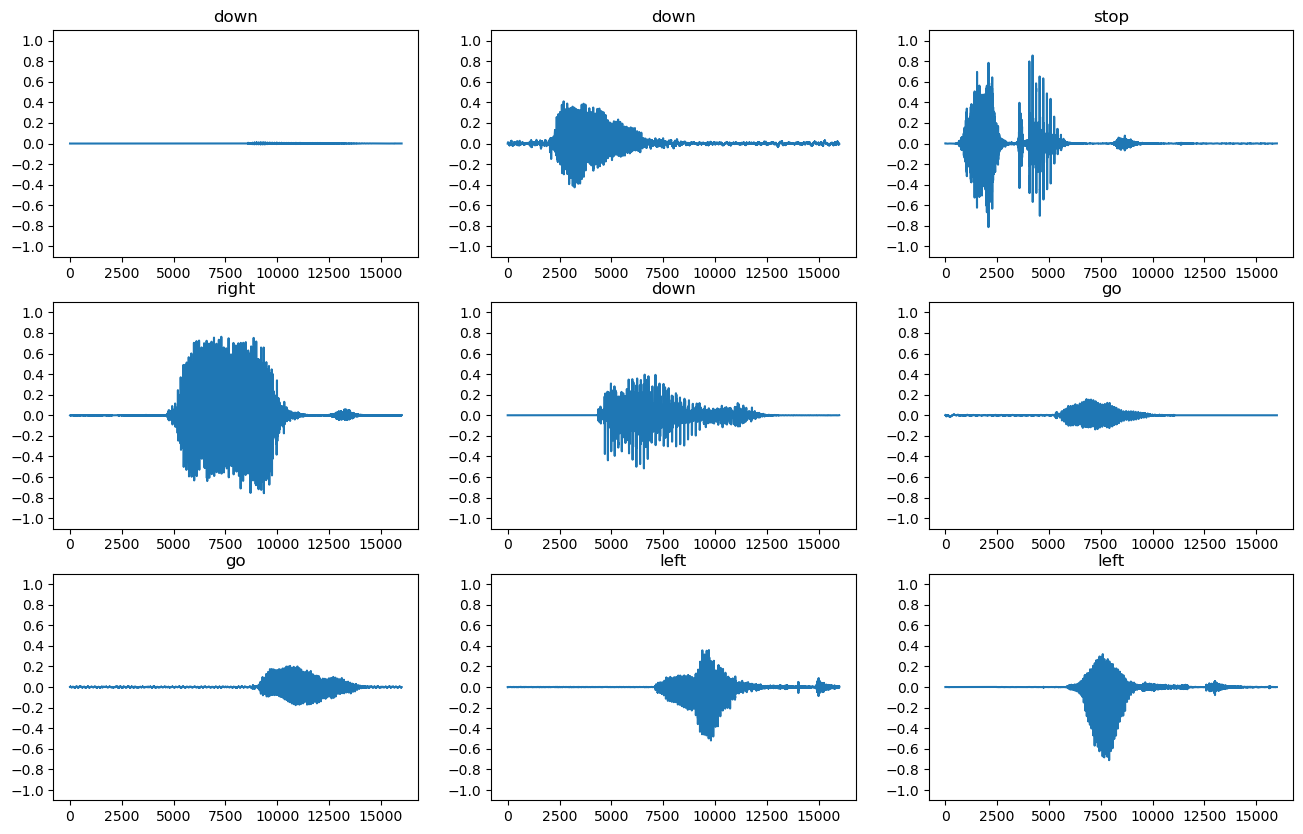

In [7]:
# So here we take the first entry in train_ds and print out audio and labels. As we defined above, train_ds has a batch
# size of 64 and a sequence length of 16000. This means example_audio will be (64,16000) indexing each audio sample
# in the batch and allowing us to access its 16000 "signal" values. We can load more batches by increasing the arg-
# -ument in take.
# 6400 training files, 64 batch size, meaning 100 batches. NOTE: train_ds.take can take any argument, and not throw
# an error, but is of course limited to 100. 
# Note: if tf.keras.utils.audio_dataset_from_directory() does not set shuffle=False, then .take argument 
# produces random data regardless of argument. If shuffle=False, we get set results.
# beneath when .take(2) vs. .take(3) to see difference
count = 0
for example_audio, example_labels in train_ds.take(4):
    count += 1
    print(count)
    print(example_audio.shape)
    print(example_labels.shape)
    
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
plt.show()

**What are these plots showing?** 

These plots can be thought of as plotting the air pressure as a function of time. This is essentially a mathematical representation of a mechanical sound wave. Since the capturing of the sound wave occurs over 1 second, and we are
operating at 16000 Hz, then we have 16000 data points in the 1-second time frame. This is the precise definition of
sample rate:
"Sample rate is the number of samples per second that are taken of a waveform to create a discrete digital signal.
https://manual.audacityteam.org/man/sample_rates.html."
 .wav is a digital signal, so we can think of it as taking a numerical reading of the sound
waves pressure 16000 times every second. Another typical sample rate is 44.1kHz, which would captured significantly more data.
So the x-axis could be considered as the sample number, and the y-axis its pressure value.

**Further details on Fourier transforms**

From https://en.wikipedia.org/wiki/Short-time_Fourier_transform, and the discrete STFT therein, m indexes the
sample number/chunks of time, w is the frequency and $|X(m,w)|^2$ is the power spectral density. Essentially,
we can think of the spectogram being a matrix/2d array, where m is the $x$-axis (time), $w$ is the y-axis (freq) and
$X(m_0,w_0)$ (or probably more commonly, the squared version) is the density/colour value of the pixel at $m=m_0$, $w =w_0$.


In order to mathematically describe the signal we start with, the fourier transform
expresses it in terms of an infinite number of sine waves/cos waves each with different phases/frequencies/amplitudes.
So this is where the frequency and amplitude data comes from when we fourier transform our signal: it is the decomposition of the signal into a superposition of waves with different frequencies and amplitudes.

We should use the discrete STFT since we have a discrete number of signal samples (a sample taken
each 1/16000 of a second. Say our signal is $x[n]$. That is, for each sample indexed by $n$, we can generate the signal value, $x[n]$, so in the figures above $x[n]$ is the y-axis, $n$ is the x-axis. Now the formula sums from $n = -\infty$ to $+\infty$ and this on its own makes no sense, since we do not have infinity samples.
However, the formula introduces a window function $w(n-m)$ that multiplies our signal, and is non-zero only for a short
amount of time. So for each frame we select we can apply a discrete fourier transform to it. This gives us back a
complex function of k (the frequency proxy). Note the number of frequencies/frequency modes we should plot is equivalent to the
number of samples in the frame we are looking at. Usually due to redundancies from complex conjugation, this can be halved. See https://www.youtube.com/watch?v=-Yxj3yfvY-4 for examples.

In [8]:
def get_spectrogram(waveform):
    """ Convert the waveform to a spectrogram via a STFT. 
    frame_step = value to move each frame by along the time axis.
    frame_length = size of frame or size of window.
    The stft introduces an extra dimension - where we only had t before, we now have k (frequency) as well.
    By arguments made for mapping between time and frequency, the num_k=frame_length/2 +1."""
    frame_length_var, frame_step_var = 255,128
    spectrogram = tf.signal.stft(
        waveform, frame_length=frame_length_var, frame_step=frame_step_var)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

X has shape (M,N) in plot.imshow(X). The first two dimensions (M, N) define the rows and columns of the image.

Also the output of tf.signal.stft() is `[batch num, frames, fft_unique_bins]` where `fft_unique_bins` correspond to the k, frequency mode index we keep. `fft_unique_bins` is `fft_length // 2 + 1`. Output `frames` is the number of frames used along the whole duration of time and equal to `sample_number`/`frame_length+1`= 16000/`frame_length+1`, up to rounding.

Note as well, if `fft_length` is not provided as an argument in .stft (which it isn't), it uses the smallest power of 2 enclosing `frame_length`, then imposes the `fft_unique_bins` is `fft_length // 2 + 1` rule. E.g. with no `fft_length` argument and `frame_length=255`, it sets `fft_length =256` (smallest power of 2 enclosing `frame_length`), then gives  `fft_unique_bins =256/2 +1`

In [11]:
frame_length_var2, frame_step_var2 = 255,128
print("frames = ", 16000/(frame_step_var2+1))
print("frequency modes n_k = ", (frame_length_var2+1)/2 +1) # Note the plus one as per .stft definition
print(get_spectrogram(example_audio)[0].shape)

frames =  124.03100775193798
frequency modes n_k =  129.0
(124, 129, 1)


In [ ]:
#Careful with axes on these plots! as of now - x-axis is the frequency axis, y-axis is time. This is how plt.imshow() plots,
# X has shape (M,N) in plot.imshow(X). The first two dimensions (M, N) define the rows and columns of the image.

# print(get_spectrogram(example_audio)[0].shape)
# plt.imshow(get_spectrogram(example_audio[1]))
# plt.show()
# plt.imshow(get_spectrogram(example_audio[2]))
# plt.show()
# help(tf.signal.stft)

In [12]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero. In built method
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

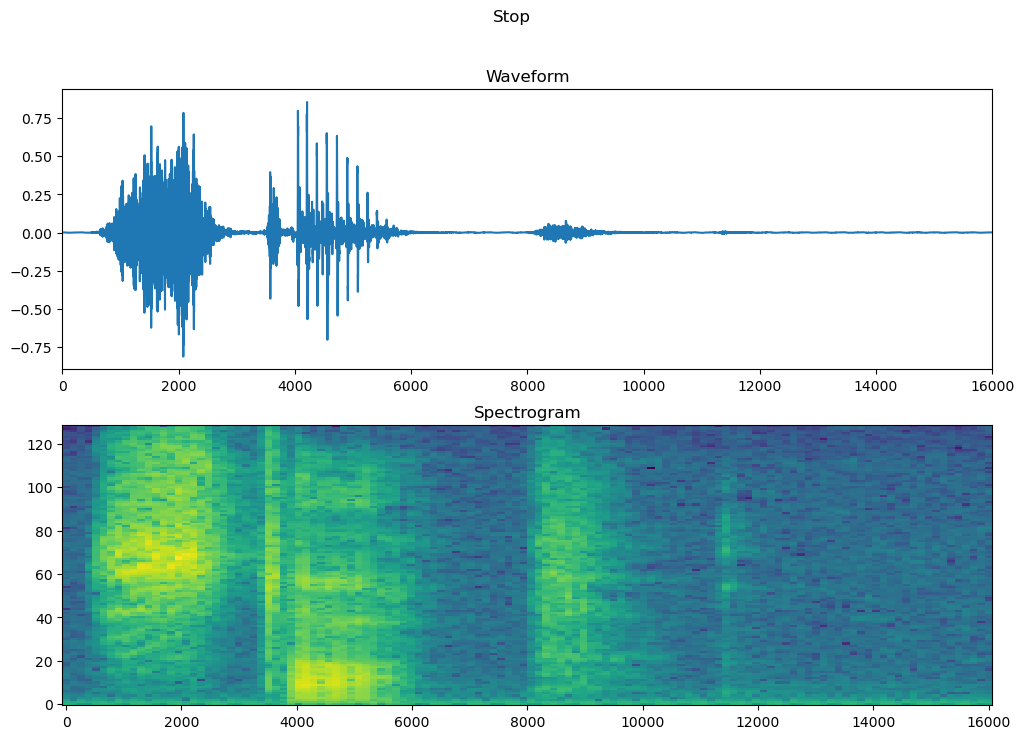

In [15]:
# `spectrogram` and `waveform` come from previous cells loop. Where we print the audio widget. We plot them together,
# to show how the Fourier transform represents the intensity as a function of time and frequency.
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [19]:
##############Training section #######################
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

# Printing the first batch of associated true labels to the sound clips
example_spect_labels

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([3, 0, 1, 4, 3, 6, 0, 7, 4, 0, 1, 7, 6, 6, 1, 7, 0, 5, 7, 4, 0, 4,
       7, 1, 5, 0, 2, 2, 2, 0, 0, 4, 1, 4, 2, 6, 6, 1, 4, 3, 3, 2, 6, 0,
       4, 2, 5, 2, 5, 6, 1, 0, 7, 0, 4, 6, 1, 5, 2, 3, 0, 4, 7, 1])>

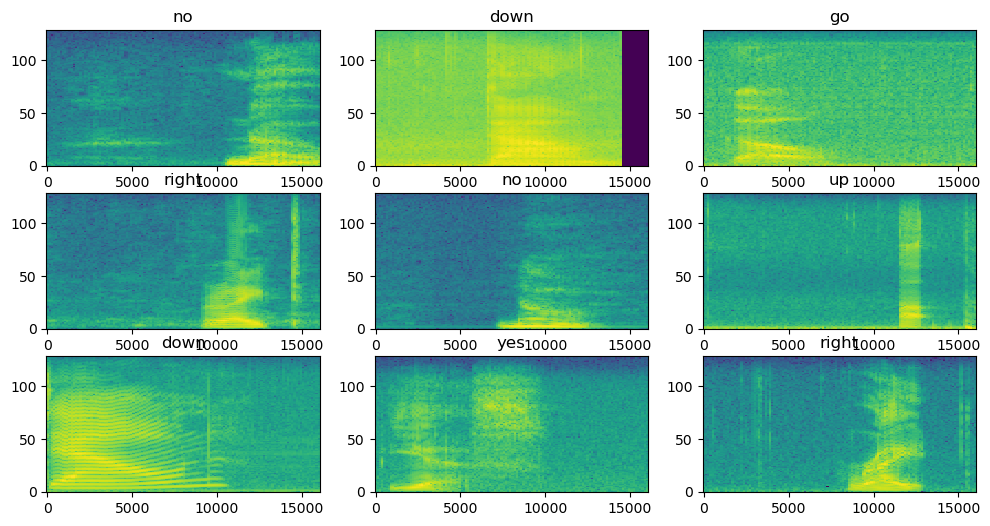

In [20]:
# A few plots. Some potentially padded up to make it up to the 16000 sample.
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [22]:
# Building the network

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

dropout_val1=0.25
dropout_val2=0.5
#Resizing images and pixel value renormalisation/scaling helps the training.
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# We can choose to have softmax activation to avoid logits output at the end. Either way, we can 
# call argmax to obtain prediction classes at the end. If softmax chosen, from_logits does not 
# need to be True
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout_val1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(dropout_val2),
    layers.Dense(10, activation='softmax'),
    #layers.Dense(num_labels),
])

#adam optimiser and sparse categorial crossentropy loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Input shape: (124, 129, 1)
Epoch 1/20
100/100 [==============================] - 4s 37ms/step - loss: 1.8004 - accuracy: 0.3391 - val_loss: 1.3320 - val_accuracy: 0.6055
Epoch 2/20
100/100 [==============================] - 4s 36ms/step - loss: 1.2513 - accuracy: 0.5519 - val_loss: 0.9930 - val_accuracy: 0.6901
Epoch 3/20
100/100 [==============================] - 3s 34ms/step - loss: 0.9565 - accuracy: 0.6567 - val_loss: 0.7990 - val_accuracy: 0.7461
Epoch 4/20
100/100 [==============================] - 3s 34ms/step - loss: 0.7719 - accuracy: 0.7283 - val_loss: 0.6930 - val_accuracy: 0.7786
Epoch 5/20
100/100 [==============================] - 3s 34ms/step - loss: 0.6714 - accuracy: 0.7619 - val_loss: 0.6194 - val_accuracy: 0.7995
Epoch 6/20
100/100 [==============================] - 3s 34ms/step - loss: 0.5734 - accuracy: 0.7917 - val_loss: 0.5644 - val_accuracy: 0.8242
Epoch 7/20
100/100 [==============================] - 3s 34ms/step - loss: 0.5154 - accuracy: 0.8159 - val_loss: 0.

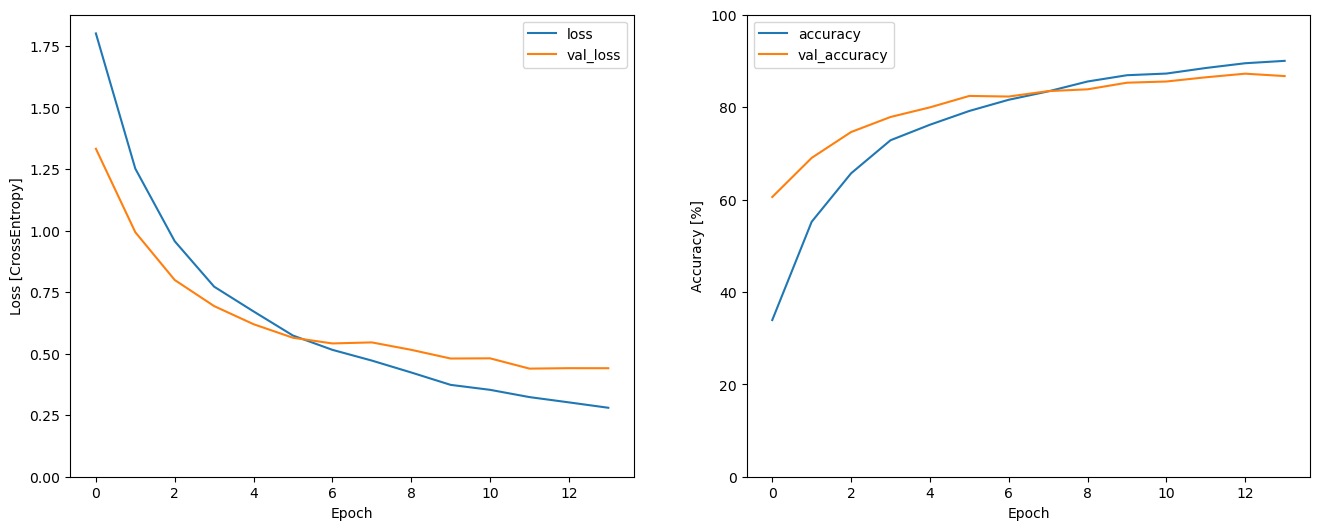

In [23]:
# Printing loss and accuracy of train and validation sets

metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

In [25]:
# Applying the model on the test data

model.evaluate(test_spectrogram_ds, return_dict=True)
y_pred = model.predict(test_spectrogram_ds)
print(y_pred[0]) 
# With just a final dense layer and no softmax acitvation function, the output will be in logits, not in probabilities 
# With with softmax activation, the output is in probabilities. In either case we can still call np.argmax()
# to extract prediction.
y_pred = tf.argmax(y_pred, axis=1) # Uses axis=1 to check which of the labels/classes has the largest output
print(y_pred[0]) 

13/13 [==============================] - 0s 8ms/step
[1.4091330e-13 3.2367153e-10 1.3798678e-04 7.2129699e-16 1.5391546e-09
 1.4273866e-06 9.9986053e-01 5.6638808e-12 1.9260356e-19 2.0351529e-19]
tf.Tensor(6, shape=(), dtype=int64)


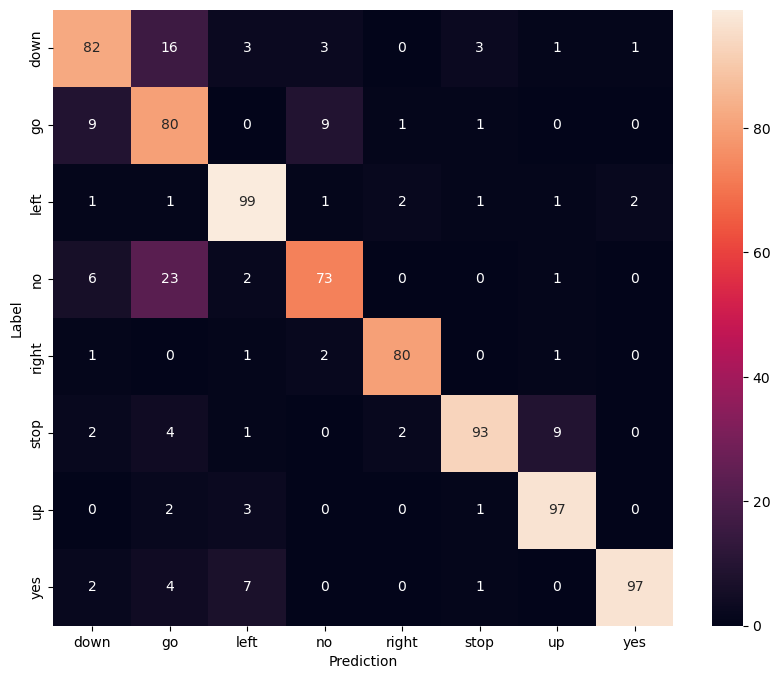

In [27]:
# Seaborn confusion matrix of data. Model performs very well distinguishing between words

y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [32]:
# Verifying confusion matrix numbers
#print(len(y_pred))
#print(y_pred[2].numpy())
count_suc=0
count_fail=0
label_test = 2
for i in range(len(y_pred)):
    if y_true[i].numpy() ==label_test and y_true[i].numpy()== y_pred[i].numpy():
        count_suc+=1
    elif y_true[i].numpy() ==label_test and y_true[i].numpy() != y_pred[i].numpy():
        count_fail+=1
print("label", label_test,"has", count_suc, "successfull classifications")
print("label", label_test,"has", count_fail, "unsuccessfull classifications")

label 2 has 99 successfull classifications
label 2 has 9 unsuccessfull classifications
